In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from gym import Env, spaces
import random
import itertools
import pickle

In [2]:
historical_data_wholesale = pd.read_csv('../Notebooks/experiment/curr_data.csv')
historical_data_buyback = pd.read_csv('../Notebooks/experiment/curr_data_bb.csv')
historical_data_revenue_sharing = pd.read_csv('../Notebooks/experiment/curr_data_rs.csv')
behavioral_data = pd.read_csv('../adjusted_reponse_survey.csv')

In [3]:
behavioral_data.columns = behavioral_data.columns.str.strip()
historical_data_wholesale.columns = historical_data_wholesale.columns.str.strip()
historical_data_buyback.columns = historical_data_buyback.columns.str.strip()
historical_data_revenue_sharing.columns = historical_data_revenue_sharing.columns.str.strip()

In [4]:
historical_data_wholesale.columns = historical_data_wholesale.columns.str.replace(' ', '_')
historical_data_buyback.columns = historical_data_buyback.columns.str.replace(' ', '_')
historical_data_revenue_sharing.columns = historical_data_revenue_sharing.columns.str.replace(' ', '_')

In [5]:
# Function to categorize retailer behavior based on stock and optimal stock
def categorize_behavior(row):
    """
    Categorizes retailer behavior as understocking, optimal, or overstocking.

    Args:
        row: A row from the historical data DataFrame.

    Returns:
        An integer representing the behavioral category:
        0: Understocking (Stock < Optimal * 0.8)
        1: Optimal Stocking (Optimal * 0.8 <= Stock <= Optimal * 1.2)
        2: Overstocking (Stock > Optimal * 1.2)
    """
    stock = row['Stock']
    optimal_stock = row["Optimal_Stock"]

    try:
        optimal_stock = float(optimal_stock)  # Try converting to float
    except ValueError:
        optimal_stock = 0  # Set to 0 if conversion fails

    if stock < optimal_stock * 0.8:
        return 0  # Understocking
    
    elif stock <= optimal_stock * 0.9:
        return 1  # Understocking
    
    elif stock <= optimal_stock:
        return 2  # Optimal Stocking
    
    elif stock <= optimal_stock * 1.1:
        return 3  # Overstocking

    else:
        return 4  # Overstocking

# Apply categorization to each dataset
historical_data_wholesale['Behavioral_Category'] = historical_data_wholesale.apply(categorize_behavior, axis=1)
historical_data_buyback['Behavioral_Category'] = historical_data_buyback.apply(categorize_behavior, axis=1)
historical_data_revenue_sharing['Behavioral_Category'] = historical_data_revenue_sharing.apply(categorize_behavior, axis=1)

# 2. Remove Extra 'Behavioral_Category' Columns
def remove_extra_columns(df, column_name):
    """Removes extra columns with the given name, keeping only the last one."""
    cols = df.columns.tolist()
    count = cols.count(column_name)
    if count > 1:
        indices = [i for i, x in enumerate(cols) if x == column_name]
        for i in indices[:-1]:  # Remove all but the last one
            df.drop(df.columns[i], axis=1, inplace=True)

remove_extra_columns(historical_data_wholesale, "Behavioral_Category")
remove_extra_columns(historical_data_buyback, "Behavioral_Category")
remove_extra_columns(historical_data_revenue_sharing, "Behavioral_Category")

# Save the updated data
historical_data_wholesale.to_csv('../Notebooks/experiment/curr_data.csv', index=False)
historical_data_buyback.to_csv('../Notebooks/experiment/curr_data_bb.csv', index=False)
historical_data_revenue_sharing.to_csv('../Notebooks/experiment/curr_data_rs.csv', index=False)

In [6]:
# Extract Traits
def extract_traits(behavioral_data):
    # Ensure that column names match exactly
    # Also note: If your columns in behavioral_data start with 'Manufacturer_' or 'Retailer_',
    # you should rename them consistently. If you don't need to strip the prefixes completely,
    # consider using them as is. Adjust as necessary.
    manufacturers = behavioral_data[[
        'Manufacturer_Self Esteem Average',
        'Manufacturer_Regret Scale Average',
        'Manufacturer_Risk Averse Coefficient',
        'Manufacturer_Fairness Index',
        'PLAYER NAME'
    ]]

    retailers = behavioral_data[[
        'Retailer_Self Esteem Average',
        'Retailer_Regret Scale Average',
        'Retailer_Risk Averse Coefficient',
        'Retailer_Fairness Index',
        'PLAYER NAME'
    ]]

    manufacturer_traits = {}
    for _, row in manufacturers.iterrows():
        # Here 'PLAYER NAME' should be a single, hashable value (string or int)
        pid = row['PLAYER NAME'].iloc[0]
        manufacturer_traits[pid] = {
            'Self Esteem Average': row['Manufacturer_Self Esteem Average'],
            'Regret Scale Average': row['Manufacturer_Regret Scale Average'],
            'Risk Averse Coefficient': row['Manufacturer_Risk Averse Coefficient'],
            'Fairness Index': row['Manufacturer_Fairness Index']
        }

    retailer_traits = {}
    for _, row in retailers.iterrows():
        pid = row['PLAYER NAME'].iloc[1]
        retailer_traits[pid] = {
            'Self Esteem Average': row['Retailer_Self Esteem Average'],
            'Regret Scale Average': row['Retailer_Regret Scale Average'],
            'Risk Averse Coefficient': row['Retailer_Risk Averse Coefficient'],
            'Fairness Index': row['Retailer_Fairness Index']
        }

    return manufacturer_traits, retailer_traits

manufacturer_traits_dict, retailer_traits_dict = extract_traits(behavioral_data)

In [7]:
potential_demand = np.arange(50, 151)  # Possible demand values from 50 to 150
stock_list = np.arange(50, 151)       # Possible stock values from 50 to 150
expected_sales = {}                   # Dictionary to store expected sales


for stock in stock_list:
    cumulative_expected_sales = 0
    for demand_realization in potential_demand:
        sales = min(demand_realization, stock)
        cumulative_expected_sales += sales

    # Calculate the average sales and store it in the dictionary
    expected_sales[stock] = cumulative_expected_sales / len(potential_demand)

In [8]:
class SupplyChainEnv(Env):
    def __init__(self, contract_type="wholesale", expected_sales=None):
        super(SupplyChainEnv, self).__init__()
        self.contract_type = contract_type
        self.max_stock = 150
        self.min_w = 3
        self.max_price = 12
        self.max_rounds = 10000  #40 tan 100 e cekildi
        self.current_round = 0
        self.demand = 0
        self.expected_sales = expected_sales

        if self.contract_type == "wholesale":
            self.manufacturer_action_space = spaces.Discrete(
                self.max_price - self.min_w + 1
            )
            self.retailer_action_space = spaces.Discrete(5)
        elif self.contract_type == "buyback":
            self.manufacturer_action_space = spaces.MultiDiscrete(
                [self.max_price - self.min_w + 1, self.max_price + 1]
            )
            self.retailer_action_space = spaces.Discrete(5)
        elif self.contract_type == "revenue-sharing":
            self.manufacturer_action_space = spaces.MultiDiscrete(
                [self.max_price - self.min_w + 1, self.max_price + 1]
            )
            self.retailer_action_space = spaces.Discrete(5)
        else:
            raise ValueError("Invalid contract type.")

        self.observation_space = spaces.Box(
            low=0, high=150, shape=(3,), dtype=np.float32
        )
        self.reset()

    def reset(self):
        self.state = np.array([0, 0, 0])
        self.current_round = 0
        self.demand = 0
        return self.state

    def manufacturer_step(self, action):
        if self.contract_type == "wholesale":
            w = action + self.min_w
            b = 0
            r = 0
        elif self.contract_type == "buyback":
            w = action[0] + self.min_w
            b = action[1]
            r = 0
        elif self.contract_type == "revenue-sharing":
            w = action[0] + self.min_w
            r = action[1]
            b = 0

        self.state = np.array([w, b, r])
        return self.state

    def get_optimal_stock(self):
        w, b, r = self.state
        if self.contract_type == "wholesale":
            optimal_stock = 100 * ((12 - w) / 12) + 50
        elif self.contract_type == "buyback":
            if b == 12:
                optimal_stock = 150
            else:
                optimal_stock = 100 * ((12 - w) / (12 - b)) + 50
        elif self.contract_type == "revenue-sharing":
            if r == 12:
                optimal_stock = 0
            else:
                optimal_stock = 100 * ((12 - w - r) / (12 - r)) + 50
        else:
            optimal_stock = 100
        return optimal_stock

    def retailer_step(self, action):
        w, b, r = self.state

        if self.contract_type == "wholesale":
            optimal_stock = 100 * ((12 - w) / 12) + 50
        elif self.contract_type == "buyback":
            if b == 12:
                optimal_stock = 150
            else:
                optimal_stock = 100 * ((12 - w) / (12 - b)) + 50
        elif self.contract_type == "revenue-sharing":
            if r == 12:
                optimal_stock = 0
            else:
                optimal_stock = 100 * ((12 - w - r) / (12 - r)) + 50
        else:
            optimal_stock = 100

        if action == 0:
            Q = optimal_stock * 0.8
        elif action == 1:
            Q = optimal_stock * 0.9
        elif action == 2:
            Q = optimal_stock
        elif action == 3:
            Q = optimal_stock * 1.1
        elif action == 4:
            Q = optimal_stock * 1.2
        else:
            Q = optimal_stock

        Q = int(round(Q))
        Q = max(0, min(Q, self.max_stock))

        sales = self.expected_sales.get(Q, 0)
        leftovers = Q - sales
        c = 3
        p = 12

        if self.contract_type == "wholesale":
            retailer_profit = p * sales - w * Q
            manufacturer_profit = (w - c) * Q
            retailer_max = p * sales - w * optimal_stock
        elif self.contract_type == "buyback":
            if b > w:
                b = w
            retailer_profit = p * sales - w * Q + b * leftovers
            manufacturer_profit = (w - c) * Q - b * leftovers
            retailer_max =p * sales - w * optimal_stock + b * leftovers
        elif self.contract_type == "revenue-sharing":
            max_revenue_share = p - w
            if r > max_revenue_share:
                r = max_revenue_share
            retailer_profit = (p - r) * sales - w * Q
            manufacturer_profit = (w - c) * Q + r * sales
            retailer_max = (p - r) * sales - w * optimal_stock

        self.current_round += 1
        done = self.current_round >= self.max_rounds
        return self.state, (manufacturer_profit, retailer_profit), done, {}

In [9]:
# Q-Learning Agent without fixed personality, but using opponent traits
class QLearningAgent:
    def __init__(
        self,
        action_space,
        learning_rate=0.05,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.000125,
        min_epsilon=0.00,
    ):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = defaultdict(float)

        # When playing against random humans (unknown traits), we will estimate them.
        # Start with some default (neutral) trait estimates:
        self.estimated_opponent_traits = {
            "Risk Averse Coefficient": 0.5,
            "Fairness Index": 0.5,
            "Regret Scale Average": 0.0,
            "Self Esteem Average": 0.0,
        }

        self.human_actions = []
        self.opponent_action_history = []
        self.behavior_change_threshold = 2

    def _state_to_key(self, state, opponent_traits):
        # Incorporate opponent traits into the Q-state key
        # Sort keys for consistency
        trait_items = tuple(sorted(opponent_traits.items()))
        return tuple(state) # + trait_items

    def get_possible_actions(self):
        if isinstance(self.action_space, spaces.Discrete):
            return range(self.action_space.n)
        elif isinstance(self.action_space, spaces.MultiDiscrete):
            ranges = [range(n) for n in self.action_space.nvec]
            return list(itertools.product(*ranges))

    def get_frozen_action_manufacturer(self, state, opponent_traits=None):
        """
        Always returns the same predefined action for the manufacturer.

        Args:
            state: The current state of the environment (unused in this function).
            opponent_traits: Traits of the opponent (unused in this function).

        Returns:
            The same predefined action for every call.
        """
        # Define the action you want the manufacturer to always take.
        # This action must be valid for the manufacturer's action space.
        if not hasattr(self, 'frozen_action1'):
            self.frozen_action1 = self.action_space.sample()  # Set a default action once.
        
        return self.frozen_action1
        
    def get_frozen_action_retailer(self, state, opponent_traits=None):
        """
        Always returns the same predefined action for the retailer.

        Args:
            state: The current state of the environment (unused in this function).
            opponent_traits: Traits of the opponent (unused in this function).

        Returns:
            The same predefined action for every call.
        """
        # Define the action you want the retailer to always take.
        # This action must be valid for the retailer's action space.
        if not hasattr(self, 'frozen_action2'):
            self.frozen_action2 = self.action_space.sample()  # Set a default action once.
        
        return self.frozen_action2


    def get_action(self, state, opponent_traits=None):
        if opponent_traits is None:
            opponent_traits = self.estimated_opponent_traits

        # Adjust epsilon using opponent's traits:
        # Example: If opponent is very risk-averse, we exploit more (lower epsilon).
        # If Risk Averse Coefficient > 0.5, reduce epsilon more aggressively.
        risk_aversion = opponent_traits.get("Risk Averse Coefficient", 0.5)
        self.epsilon = max(
            self.min_epsilon,
            self.epsilon - self.epsilon_decay  # * (1.0 - (risk_aversion - 0.5))
        )

        if np.random.rand() < self.epsilon:
            return self.action_space.sample() if not isinstance(self.action_space, spaces.MultiDiscrete) else tuple(self.action_space.sample())
        else:
            state_key = self._state_to_key(state, opponent_traits)
            possible_actions = self.get_possible_actions()
            q_values = [self.q_table[(state_key, a)] for a in possible_actions]
            max_q = max(q_values)
            max_actions = [a for a, q in zip(possible_actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def update_q_table(self, state, action, reward, next_state, current_opponent_traits, next_opponent_traits):
        state_key = self._state_to_key(state, current_opponent_traits)
        next_state_key = self._state_to_key(next_state, next_opponent_traits)
        possible_actions = self.get_possible_actions()
        max_next_q = max([self.q_table[(next_state_key, a)] for a in possible_actions], default=0)
        # No reward shaping by traits, just regular Q-update
        self.q_table[(state_key, action)] += self.learning_rate * (
            reward + self.discount_factor * max_next_q - self.q_table[(state_key, action)]
        )

    def update_opponent_model(self, opponent_action):
        self.human_actions.append(opponent_action)
        # Example heuristic: If variance of actions is low, opponent is more risk-averse
        if len(self.human_actions) > 10:
            recent_actions = self.human_actions[-10:]
            action_variance = np.var(recent_actions)
            max_variance = ((self.action_space.n - 1) ** 2 / 12 if isinstance(self.action_space, spaces.Discrete) else 1)
            # Adjust estimated opponent risk aversion based on action variance
            new_risk = max(0, min(1, 1 - action_variance / max_variance))
            self.estimated_opponent_traits["Risk Averse Coefficient"] = new_risk

    def save_agent(self, filename):
        agent_data = {
            "q_table": self.q_table,
            "learning_rate": self.learning_rate,
            "discount_factor": self.discount_factor,
            "epsilon": self.epsilon,
            "initial_epsilon": self.initial_epsilon,
            "epsilon_decay": self.epsilon_decay,
            "min_epsilon": self.min_epsilon,
        }
        with open(filename, "wb") as f:
            pickle.dump(agent_data, f)

    def load_agent(self, filename):
        with open(filename, "rb") as f:
            agent_data = pickle.load(f)
        self.q_table = agent_data["q_table"]
        self.learning_rate = agent_data["learning_rate"]
        self.discount_factor = agent_data["discount_factor"]
        self.epsilon = agent_data["epsilon"]
        self.initial_epsilon = agent_data["initial_epsilon"]
        self.epsilon_decay = agent_data["epsilon_decay"]
        self.min_epsilon = agent_data["min_epsilon"]

    def update_q_value(self, state, action, reward, next_state):
        """
        Standard Q-Learning update.
        """
        possible_actions = self.get_possible_actions()
        next_qs = [self.q_table[(tuple(next_state), a)] for a in possible_actions]
        max_next_q = max(next_qs) if next_qs else 0.0

        old_q = self.q_table[(tuple(state), action)]
        new_q = old_q + self.learning_rate * (reward + self.discount_factor * max_next_q - old_q)
        self.q_table[(tuple(state), action)] = new_q

    def decay_epsilon(self):
        """
        Decay epsilon after each step if desired.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)


    



In [10]:
def preprocess_historical_data(df, contract_type, manufacturer_traits_dict, retailer_traits_dict):
    # We assume df has 'Manufacturer_ID' and 'Retailer_ID' columns to match traits
    data = []
    num_rows = len(df)
    rows_per_game = 50
    for start_row in range(0, num_rows, rows_per_game):
        game_data = df.iloc[start_row : start_row + rows_per_game]
        for _, row in game_data.iterrows():
            wholesale_price = float(row["Wholesale_p."])
            buyback_price = float(row["Buyback_p."]) if "Buyback_p." in row and not pd.isnull(row["Buyback_p."]) else 0.0
            revenue_share = float(row["Revenue_Share"]) if "Revenue_Share" in row and not pd.isnull(row["Revenue_Share"]) else 0.0

            state = [wholesale_price, buyback_price, revenue_share]

            if contract_type == "wholesale":
                manufacturer_action = wholesale_price - 3
            elif contract_type == "buyback":
                manufacturer_action = (wholesale_price - 3, buyback_price)
            elif contract_type == "revenue-sharing":
                manufacturer_action = (wholesale_price - 3, revenue_share)
            else:
                manufacturer_action = (wholesale_price - 3, 0.0)

            retailer_action = int(row["Behavioral_Category"])

            try:
                manufacturer_reward = float(row["Realized_Mfg_Profit"])
            except ValueError:
                manufacturer_reward = 0
            try:
                retailer_reward = float(row["Realized_Retailer_Profit"])
            except ValueError:
                retailer_reward = 0

            next_state = [wholesale_price, buyback_price, revenue_share]

            # Extract player IDs
            mfg_id = row["Manufacturer_ID"] if "Manufacturer_ID" in row else None
            ret_id = row["Retailer_ID"] if "Retailer_ID" in row else None

            # Default neutral traits if not found
            default_traits = {
                'Self Esteem Average': 0.0,
                'Regret Scale Average': 0.0,
                'Risk Averse Coefficient': 0.5,
                'Fairness Index': 0.5
            }

            # Identify which side is the "opponent"
            # If we are training a manufacturer agent, the opponent is retailer, and vice versa.
            # Let's store both sets for flexibility:
            mfg_traits = manufacturer_traits_dict.get(mfg_id, default_traits)
            ret_traits = retailer_traits_dict.get(ret_id, default_traits)

            data.append(
                (
                    state,
                    manufacturer_action,
                    retailer_action,
                    (manufacturer_reward, retailer_reward),
                    next_state,
                    mfg_traits,
                    ret_traits
                )
            )
    return data

In [11]:
historical_data_wholesale_processed = preprocess_historical_data(historical_data_wholesale, "wholesale", manufacturer_traits_dict, retailer_traits_dict)
historical_data_buyback_processed = preprocess_historical_data(historical_data_buyback, "buyback", manufacturer_traits_dict, retailer_traits_dict)
historical_data_rs_processed = preprocess_historical_data(historical_data_revenue_sharing, "revenue-sharing", manufacturer_traits_dict, retailer_traits_dict)
historical_data = historical_data_wholesale_processed + historical_data_buyback_processed + historical_data_rs_processed

# Create environments
env_wholesale = SupplyChainEnv(contract_type="wholesale", expected_sales=expected_sales)
env_buyback = SupplyChainEnv(contract_type="buyback", expected_sales=expected_sales)
env_revenue_sharing = SupplyChainEnv(contract_type="revenue-sharing", expected_sales=expected_sales)

In [12]:
def train_from_scratch_each_episode(
    num_episodes=100,
    rounds_per_episode=10000,
    contract_type="wholesale",
    expected_sales=None
):
    """
    For each episode:
      - Create new environment
      - Initialize new manufacturer & retailer agents with fresh Q-tables
      - Run 10000 steps
      - Track Q-values or store them for analysis
      - ALSO log manufacturer & retailer actions each round to a CSV
    """
    # We'll still store the Q-value evolution in 'q_value_history'
    q_value_history = []

    # NEW: We'll store (episode, round, state, action, reward, etc.) in a list of dicts
    action_log = []

    for ep in range(num_episodes):
        # Fresh environment
        env = SupplyChainEnv(contract_type=contract_type, expected_sales=expected_sales)
        state = env.reset()

        # Fresh agents (both manufacturer & retailer)
        manufacturer_agent = QLearningAgent(env.manufacturer_action_space)
        retailer_agent = QLearningAgent(env.retailer_action_space)

        q_tables_per_round = []

        for round_i in range(rounds_per_episode):
            # 1) Manufacturer picks an action (frozen)
            #mfg_action = manufacturer_agent.get_action(state)
            mfg_action = manufacturer_agent.get_frozen_action_manufacturer(state)
            state_mfg = env.manufacturer_step(mfg_action)

            # 2) Retailer picks an action 
            ret_action = retailer_agent.get_action(state_mfg)
            next_state, (mfg_reward, ret_reward), done, _ = env.retailer_step(ret_action)

            # 3) Update Q-values for both agents
            manufacturer_agent.update_q_value(state, mfg_action, mfg_reward, next_state)
            retailer_agent.update_q_value(state_mfg, ret_action, ret_reward, next_state)

            # 4) Epsilon decay (optional, after each round)
            #manufacturer_agent.decay_epsilon()
            #retailer_agent.decay_epsilon()

            # -- LOG THE ACTIONS & REWARDS --
            # Convert arrays to lists if needed so they can be saved as CSV-friendly data
            action_log.append({
                "Episode": ep,
                "Round": round_i,
                "CurrentState": state.tolist() if isinstance(state, np.ndarray) else state,
                "ManufacturerAction": mfg_action,
                "RetailerAction": ret_action,
                "ManufacturerReward": mfg_reward,
                "RetailerReward": ret_reward,
                "NextState": next_state.tolist() if isinstance(next_state, np.ndarray) else next_state,
                # If you also want to record Epsilon:
                "ManufacturerEpsilon": manufacturer_agent.epsilon,
                "RetailerEpsilon": retailer_agent.epsilon
            })

            # 5) Move to next state
            state = next_state

            # Optional: store Q-tables for analysis
            q_tables_per_round.append({
                'round': round_i,
                'manufacturer_q_table': dict(manufacturer_agent.q_table),
                'retailer_q_table': dict(retailer_agent.q_table),
            })

            if done:
                break

        q_value_history.append(q_tables_per_round)
        print(f"Episode {ep+1}/{num_episodes} completed. "
              f"Final manufacturer epsilon={manufacturer_agent.epsilon:.4f}, "
              f"retailer epsilon={retailer_agent.epsilon:.4f}")

    # -- AFTER ALL EPISODES, WRITE THE LOG TO A CSV --
    df_log = pd.DataFrame(action_log)
    df_log.to_csv("actions_log.csv", index=False)
    print("All actions logged to actions_log.csv")

    return q_value_history

q_value_evolution = train_from_scratch_each_episode(
    num_episodes=1,            # how many episodes
    rounds_per_episode=10000,   # how many rounds in each episode
    contract_type="wholesale",
    expected_sales=expected_sales
)

Episode 1/1 completed. Final manufacturer epsilon=1.0000, retailer epsilon=0.0000
All actions logged to actions_log.csv


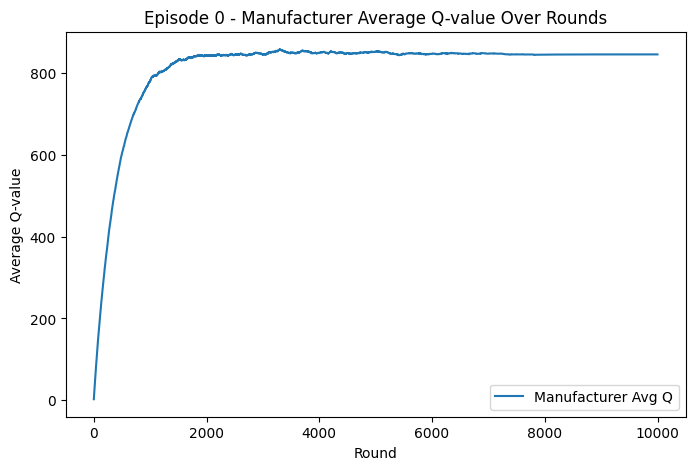

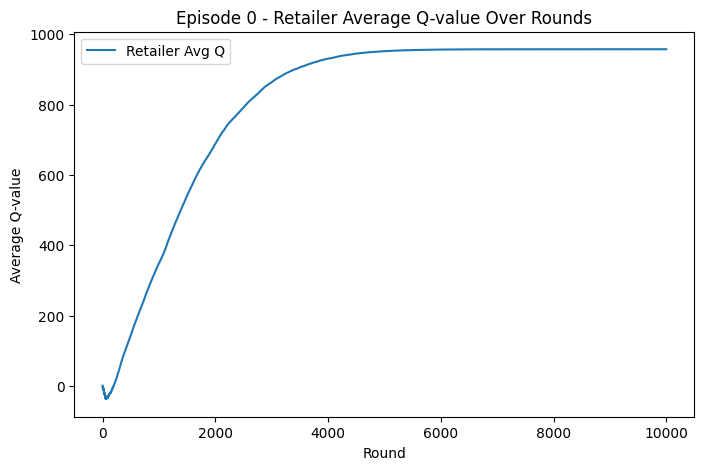

In [13]:
import matplotlib.pyplot as plt

def plot_average_q_values(q_value_evolution, episode_index=0, agent="manufacturer"):
    """
    Plots the average Q-value per round for the specified agent in a given episode.
    agent can be 'manufacturer' or 'retailer'.
    episode_index is which episode's data to plot.
    """
    round_data = q_value_evolution[episode_index]  # This is the list of rounds for one episode
    avg_q_values = []

    for rd in round_data:
        if agent == "manufacturer":
            q_table = rd["manufacturer_q_table"]
        else:
            q_table = rd["retailer_q_table"]
        
        # If Q-table is empty, average is zero (or skip)
        if len(q_table) == 0:
            avg_q_values.append(0)
            continue

        # Compute average Q-value
        sum_q = sum(q_table.values())
        avg_q = sum_q / len(q_table)
        avg_q_values.append(avg_q)

    # Now we have a list of average Q-values, one per round
    plt.figure(figsize=(8, 5))
    plt.plot(range(len(avg_q_values)), avg_q_values, label=f'{agent.capitalize()} Avg Q')
    plt.xlabel("Round")
    plt.ylabel("Average Q-value")
    plt.title(f"Episode {episode_index} - {agent.capitalize()} Average Q-value Over Rounds")
    plt.legend()
    plt.show()

# Example usage: 
#   Plot average manufacturer Q for Episode 0.
#   Then do the same for retailer or another episode if you like.
plot_average_q_values(q_value_evolution, episode_index=0, agent="manufacturer")
plot_average_q_values(q_value_evolution, episode_index=0, agent="retailer")